In [1]:
import sys
sys.path.insert(0,'../')
from libs.ssl_task import CPC
from libs.ssl_data import SSLHBNDataModule
%load_ext autoreload
%autoreload 2

In [5]:
import wandb
run = wandb.init(project="eeg-ssl", job_type="training")

wandb: Currently logged in as: dt-young112 (sccn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [11]:
import os
model = "0cu5slnx" #"3k5y24ev"
artifact_dir = f'artifacts/model-{model}'
num_version = 11 if model == "0cu5slnx" else 31
for version in range(num_version):
    if os.path.exists(f'{artifact_dir}:v{version}'):
        print(f"Artifact directory {artifact_dir}:v{version} already exists. Skipping download.")
        continue
    else:
        artifact = run.use_artifact(f'sccn/eeg-ssl/model-{model}:v{version}', type='model')
        artifact_dir = artifact.download()

Artifact directory artifacts/model-0cu5slnx:v0 already exists. Skipping download.
Artifact directory artifacts/model-0cu5slnx:v1 already exists. Skipping download.
Artifact directory artifacts/model-0cu5slnx:v2 already exists. Skipping download.
Artifact directory artifacts/model-0cu5slnx:v3 already exists. Skipping download.
Artifact directory artifacts/model-0cu5slnx:v4 already exists. Skipping download.
Artifact directory artifacts/model-0cu5slnx:v5 already exists. Skipping download.
Artifact directory artifacts/model-0cu5slnx:v6 already exists. Skipping download.
Artifact directory artifacts/model-0cu5slnx:v7 already exists. Skipping download.
Artifact directory artifacts/model-0cu5slnx:v8 already exists. Skipping download.
Artifact directory artifacts/model-0cu5slnx:v9 already exists. Skipping download.
Artifact directory artifacts/model-0cu5slnx:v10 already exists. Skipping download.


In [12]:
# load config from runs/config_CPC.yaml
import yaml
import lightning as L
with open('../runs/config_CPC.yaml', 'r') as f:
    config = yaml.safe_load(f)

ssl_task = CPC()
config['data']['ssl_task'] = ssl_task
config['data']['window_len_s'] = 20
config['data']['num_workers'] = 2

if model == "0cu5slnx":
    config['model']['init_args']['contextualizer_path'] = 'libs.ssl_model.BENDRContextualizer'
    config['model']['init_args']['contextualizer_kwargs'] = {'in_features': 512, 'start_token': None}
elif model == "3k5y24ev":
    config['model']['init_args']['contextualizer_path'] = 'libs.ssl_model.BENDRLSTM'
    config['model']['init_args']['contextualizer_kwargs'] = {'in_features': 512}

config['trainer']['callbacks'] = None
config['trainer']['logger'] = None

trainer = L.Trainer(**config['trainer'])
cpc_model = CPC.CPCLit(downsampling_factor=96, **config['model']['init_args'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
from collections import defaultdict
import json
mode = 'test'
if os.path.exists(f'model-{model}_scores-{mode}.json'):
    version_scores = json.load(open(f'model-{model}_scores-{mode}.json'))
else:
    attributes = ['age', 'p_factor']
    version_scores = defaultdict(list)
    for attr in attributes:
        config['data']['target_label'] = attr
        print('Loading data module...')
        litDataModule = SSLHBNDataModule(**config['data'])
        litDataModule.setup(stage=mode)

        artifact_dir = f'artifacts/model-{model}'
        num_version = 11 if model == "0cu5slnx" else 31
        for version in range(num_version):
            artifact_path = f'{artifact_dir}:v{version}/model.ckpt'
            print(f'Loading model from {artifact_path}...')
            scores = trainer.test(model=cpc_model, ckpt_path=artifact_path, datamodule=litDataModule)
            version_scores[attr].append(scores)

    with open(f'model-{model}_scores-{mode}.json', 'w') as f:
        json.dump(version_scores, f)


In [ ]:
# plot the metrics for each attribute for each version from scores
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as mcolors
def plot_metrics(scores, metrics, attributes, models):
    # create a color map
    cmap = cm.get_cmap('viridis', len(models))
    colors = [cmap(i) for i in range(len(models))]

    # create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # loop through each attribute and plot the metrics
    for i, model in enumerate(models):
        scores = json.load(open(f'model-{model}_scores-{mode}.json'))
        for attr in attributes:
            for metric in metrics:
                # extract the scores for the current attribute and metric
                scores_attr = [s[0][metric] for s in scores[attr]]
                # plot the scores with a line and marker
                ax.plot(range(len(scores_attr)), scores_attr, label=f'{model} - {attr} - {metric}', color=colors[i], marker='o')

    # set the x-axis ticks and labels
    ax.set_xticks(range(len(scores_attr)))
    ax.set_xticklabels([f'v{v}' for v in range(len(scores_attr))])

    # set the y-axis label
    ax.set_ylabel('Score')

    # set the title
    ax.set_title('Metrics for each attribute and version')

    # add a legend
    ax.legend()

    # show the plot
    plt.show()

In [23]:
metrics = [f'{mode}_Regressor/mae', f'{mode}_Regressor/subject_with_mean_mae']
# metrics = [f'val_Regressor/mae', f'val_Regressor/subject_with_mean_mae']

/tmp/ipykernel_1857370/1372667696.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(models))


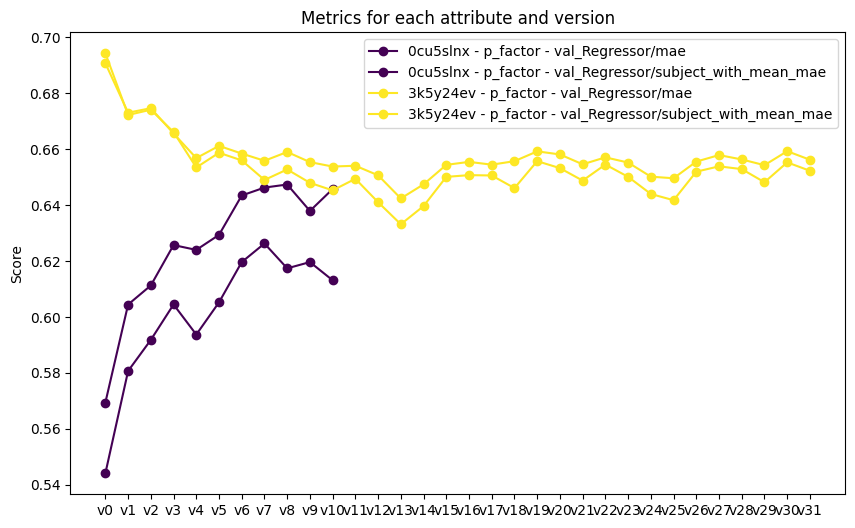

In [ ]:
attributes = ['p_factor']
plot_metrics(version_scores, metrics, attributes, ['0cu5slnx', '3k5y24ev'])

/tmp/ipykernel_1857370/1372667696.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(models))


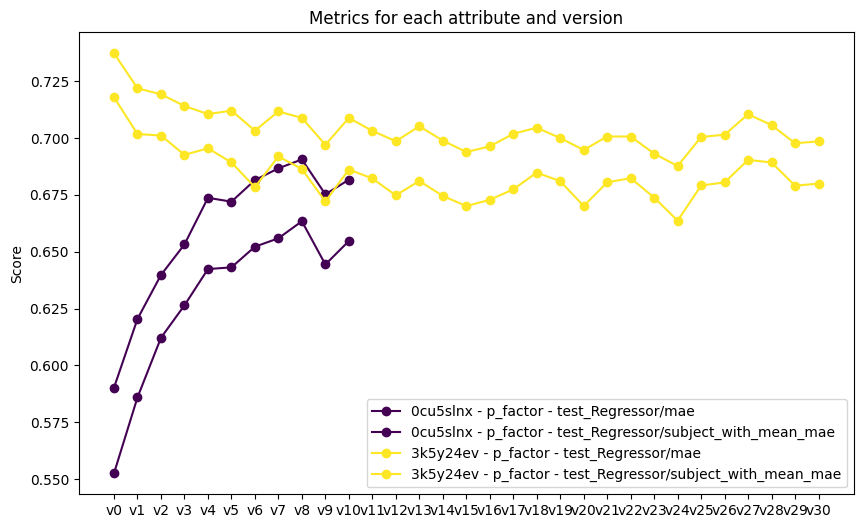

In [24]:
attributes = ['p_factor']
plot_metrics(version_scores, metrics, attributes, ['0cu5slnx', '3k5y24ev'])